In [1]:
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from video_loader import MinMaxScaler
from video_loader import VideoLoader
from video_loader import VideoClipLoader

def load_bamc_data():   
    video_path = "/shared_data/bamc_data/"
    
    transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                                 #torchvision.transforms.CenterCrop(size=(cropped_width, cropped_height)),
                                                 #torchvision.transforms.Resize(size=(width, height)), 
                                                 #MinMaxScaler(0, 255)
                                                ])
    dataset = VideoLoader(video_path, transform=transforms, num_frames=60)
    
    return dataset


In [2]:
data = load_bamc_data()
batch = [data[i][1] for i in range(len(data))]
# batch = [data[i][1] for i in range(64)]
batch = torch.stack(batch)
batch.shape

torch.Size([62, 1, 60, 1080, 1920])

In [3]:
data[0][0]

'PTX_No_Sliding'

In [4]:
from matplotlib import pyplot as plt
import torchvision.transforms as T

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(2064, 128)
        self.dropout = torch.nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import cm
from PIL import Image

class BamcPreprocessor(nn.Module):
    
    # height=600, width=1500, top_crop=0.3, bottom_crop=0.2, y_offset=80, x_scale_span=90 <- Looks good
    def __init__(self, height=400, width=700, top_crop=0.15, bottom_crop=0.05, depth=6, y_offset=80, x_scale_span=90):
        super().__init__()
        self.depth = depth
        if self.depth < 5:
            raise ValueError("depth must be >=5")

        self.top_crop = round(height * top_crop)
        self.bottom_crop = round(height * top_crop)
        self.height = height + self.top_crop + self.bottom_crop
        self.width = width
        self.y_offset = y_offset
        self.x_scale_span = x_scale_span
        self.scale_classifier = Net()
        self.scale_classifier.load_state_dict(torch.load('scale_classifier_weights.pt'))
        self.scale_classifier.eval()

    # x represents our data
    def forward(self, x):
        # x = [12, 1, 60, 182, 404]
        # [batchsize, channels, time, y, x]

        in_height = x.shape[3]
        in_width = x.shape[4]
        
        output = torch.zeros(x.shape[0], x.shape[1], x.shape[2], self.height-self.top_crop-self.bottom_crop, self.width)
        
        num_imgs = x.shape[0]
        ncol = 4
        if num_imgs // ncol == num_imgs / ncol:
            nrow = num_imgs // ncol
        else:
            nrow = num_imgs // ncol + 1
        fig, axes = plt.subplots(ncols=ncol, nrows=nrow,
                        constrained_layout=True,
                        figsize=(ncol*3, nrow*3))
        output_folder = 'scales/'
        
        for i in range(x.shape[0]):
            img = x[i, 0, :, :, :]
            
            slice_frame = img[0, self.y_offset:in_height, :self.x_scale_span]
            slice_frame[slice_frame < 40] = 0
            
            # print(slice_frame.shape)
            
            #fig = plt.gcf()
            #ax = plt.gca()
            #DPI = fig.get_dpi()
            #fig.set_size_inches(slice_frame.shape[1]/float(DPI), slice_frame.shape[0]/float(DPI))
            #plt.imshow(slice_frame)
            
            y_coord_max = torch.max(torch.where(slice_frame != 0)[0])
            y_coord_min = torch.min(torch.where(slice_frame != 0)[0])
            
            s = slice_frame[y_coord_max-21:y_coord_max, :]
            #fig = plt.gcf()
            #ax = plt.gca()
            #DPI = fig.get_dpi()
            #fig.set_size_inches(s.shape[1]/float(DPI), s.shape[0]/float(DPI))
            # plt.imshow(s)
            # print(s.shape)
            
            test = s.unsqueeze(0).unsqueeze(0).float()/254
            pred = self.scale_classifier(s.unsqueeze(0).unsqueeze(0).float()/254)
            pred_class = torch.argmax(pred, dim=1)[0]
            if pred_class == 0:
                img_size = 12
            elif pred_class == 1:
                img_size = 5
            else:
                img_size = 16
                
            # print(img_size, y_coord_max-y_coord_min)
            
            r = i // ncol
            c = i % ncol
            
            # axes[r, c].imshow(s, cmap=cm.Greys_r)

            # save_image(s, '{}scale{}.png'.format(output_folder, i))
            im = Image.fromarray(s.to('cpu', torch.uint8).numpy())
            im.save('{}scale{}.jpeg'.format(output_folder, i))
            
            scale_height = y_coord_max - y_coord_min
            
            # print(x.shape)
            
            if img_size == 5:
                extra_px = int(torch.round((y_coord_max-y_coord_min)/5 * (self.depth - 5)).item())
                crop1 = torch.zeros(x.shape[2], y_coord_max-y_coord_min + extra_px, x.shape[4])
                img_size = self.depth
            else:
                crop1 = torch.zeros(x.shape[2], y_coord_max-y_coord_min, x.shape[4])
                
            crop1[:,:y_coord_max-y_coord_min, :] = x[i, 0, :, self.y_offset+y_coord_min:self.y_offset+y_coord_max, :]
            
            # plt.imshow(crop1[0])
            # print(crop1.shape)
            
            resize_height = round(self.height * img_size / self.depth)
            resize_width = round(resize_height / crop1.shape[1] * crop1.shape[2])
            
            resized = T.Resize(size=(resize_height, resize_width))(crop1)
            crop2 = resized[:, :self.height, :]
            # plt.imshow(resized[0])
            
            center_x = round(crop2.shape[2] / 2)
            width_span = round(self.width / 2)
            crop3 = crop2[:, self.top_crop:-self.bottom_crop, center_x-width_span:center_x+width_span]
            
            axes[r, c].imshow(crop3[10], cmap=cm.Greys_r)
            axes[r, c].title.set_text('Figure {} ({}-{}cm)'.format(i, data[i][0], img_size))
            
            output[i, 0] = crop3
            
            # plt.imshow(crop2[0])
            # break
            
        return output

pp = BamcPreprocessor()
out = pp(batch)

In [ ]:
from train_conv3d_sparse_model import plot_video
from IPython.display import HTML
ani = plot_video(out[9])
HTML(ani.to_html5_video())

In [ ]:
ani = plot_video(batch[2])
HTML(ani.to_html5_video())

In [ ]:
plt.imshow(batch[9, 0, 0, :, :], cmap=cm.Greys_r)

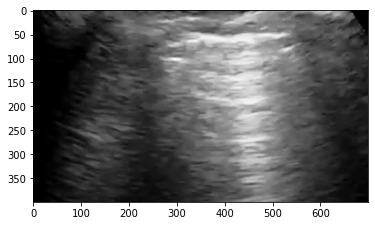

In [17]:
plt.imshow(out[9, 0, 0, :, :], cmap=cm.Greys_r)